## HEATMAPS

We test the first total_epochs


Each epoch is calculated by binning time_epoch time


All hosts in this time frame are taken into account

In [3]:
import pandas as pd
import numpy as np
%matplotlib inline

time_epoch = 60
total_epochs = 20

# hard coded nrows
df_all = pd.read_csv('../../../diploma/multi-source-syber-security-events/flows.txt', header=None, nrows=500000)

df_all.columns = ['time', 'duration', 'source computer', 'source port', 'destination computer', 
              'destination port', 'protocol', 'packet count', 'byte count']

df_all = df_all[df_all['time'] <= time_epoch * total_epochs]
df_all.index = df_all['time']
df_all.drop(columns=['time'],inplace=True)

In [4]:
# get all the host in the buckets we are interested in 

hosts = np.array(list(set(df_all['source computer'].values))) 

print('Testing a total of', len(hosts), 'hosts')

Testing a total of 1722 hosts


# First we will train on the whole dataset 
# TODO addZeros=True

# Ruins the distribution for now

In [5]:
from helper import group_scale_data, group_scale_data_batch

groupped_data, hosts, parameters = group_scale_data(df_all, size_of_bin_seconds=time_epoch,
                                                    doScale=True, addZeros=True, scaler='log', hosts=hosts, verbose=1)

A total of 20 time epochs have been encountered
Done with 0 hosts out of 1722
Done with 86 hosts out of 1722
Done with 172 hosts out of 1722
Done with 258 hosts out of 1722
Done with 344 hosts out of 1722
Done with 430 hosts out of 1722
Done with 516 hosts out of 1722
Done with 602 hosts out of 1722
Done with 688 hosts out of 1722
Done with 774 hosts out of 1722
Done with 860 hosts out of 1722
Done with 946 hosts out of 1722
Done with 1032 hosts out of 1722
Done with 1118 hosts out of 1722
Done with 1204 hosts out of 1722
Done with 1290 hosts out of 1722
Done with 1376 hosts out of 1722
Done with 1462 hosts out of 1722
Done with 1548 hosts out of 1722
Done with 1634 hosts out of 1722
Done with 1720 hosts out of 1722
Scaeling...


In [6]:
from emClustering import OnlineEM
from plots import plot_points, plot_results, plot_category, plot_all_categories
from kplusplus import KPlusPlus

In [15]:
mixtures = 15

kplusplus = KPlusPlus(mixtures, groupped_data.values[:, :2], stochastic=True, stochastic_n_samples=3000)

kplusplus.init_centers(verbose=1)

# random initialization
onlineEM = OnlineEM([1/mixtures]*mixtures, kplusplus.centers, 500, n_clusters=8, verbose=1, update_power=0.5)

Centers found: 1
Centers found: 2
Centers found: 3
Centers found: 4
Centers found: 5
Centers found: 6
Centers found: 7
Centers found: 8
Centers found: 9
Centers found: 10
Centers found: 11
Centers found: 12
Centers found: 13
Centers found: 14


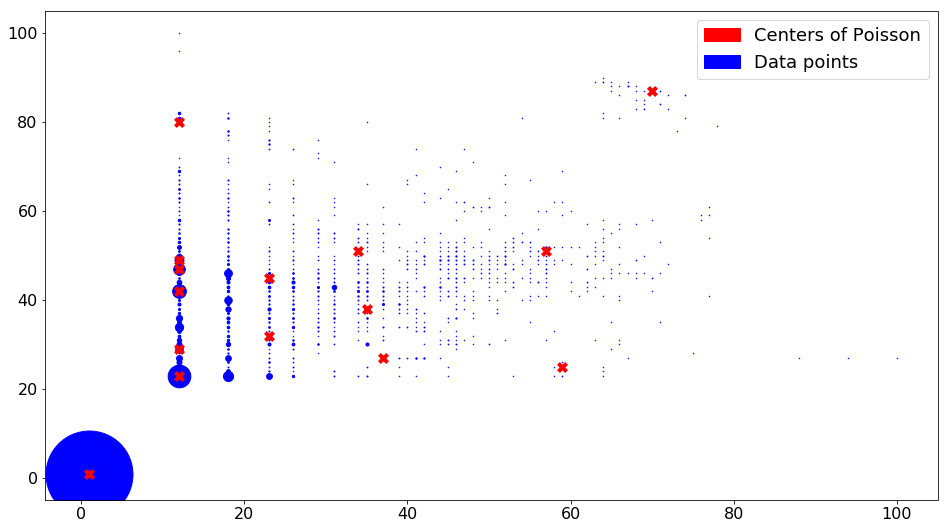

In [16]:
plot_points(groupped_data.values[:, :2], onlineEM)

In [17]:
# ignore epoch index for now

data = groupped_data.values[:,[0,1,3]]

np.random.shuffle(data)


onlineEM.fit(data)

Running for data till position 500 from total 34440
Running for data till position 1000 from total 34440
Running for data till position 1500 from total 34440
Running for data till position 2000 from total 34440
Running for data till position 2500 from total 34440
Running for data till position 3000 from total 34440
Running for data till position 3500 from total 34440
Running for data till position 4000 from total 34440
Running for data till position 4500 from total 34440
Running for data till position 5000 from total 34440
Running for data till position 5500 from total 34440
Running for data till position 6000 from total 34440
Running for data till position 6500 from total 34440
Running for data till position 7000 from total 34440
Running for data till position 7500 from total 34440
Running for data till position 8000 from total 34440
Running for data till position 8500 from total 34440
Running for data till position 9000 from total 34440
Running for data till position 9500 from total 

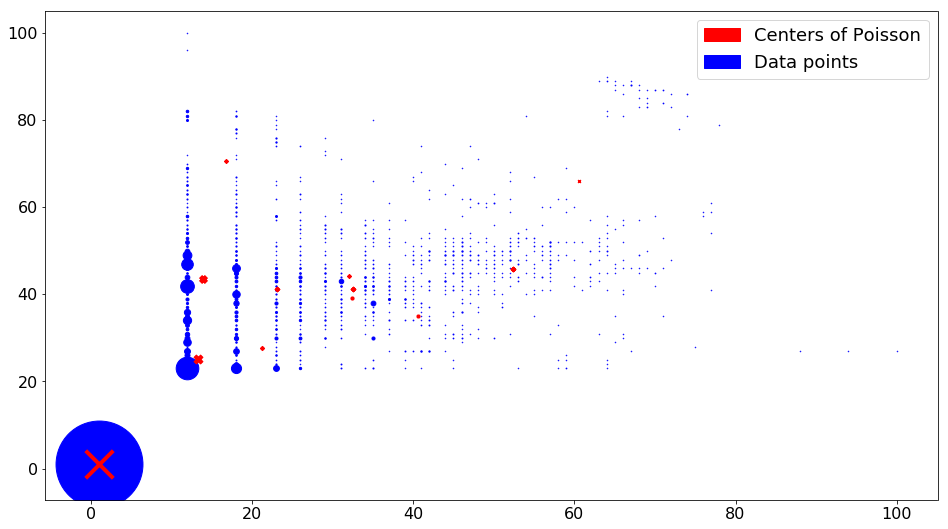

In [18]:
plot_points(groupped_data.values[:, :2], onlineEM)

### First we shall explore how the average values shift between different hosts and different epochs in our dataset

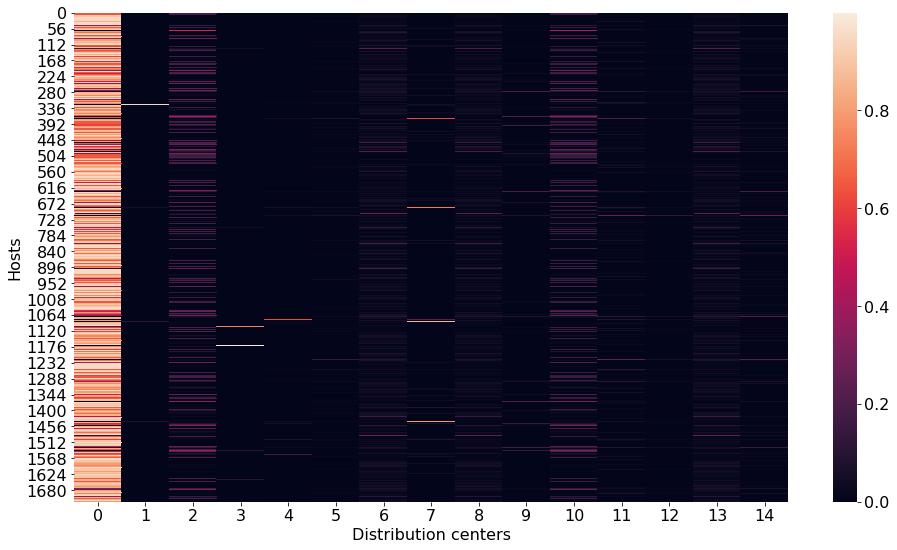

In [19]:
# HOST and clusters
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from pylab import rcParams
rcParams['figure.figsize'] = 16, 9
rcParams['font.size'] = 16

heatmap_hosts = np.zeros(shape=(len(hosts), onlineEM.m))

for i, host in enumerate(hosts):
    heatmap_hosts[i] = onlineEM.hosts[host]['group']
    
ax = sns.heatmap(heatmap_hosts)
plt.ylabel('Hosts')
plt.xlabel('Distribution centers')
plt.show()

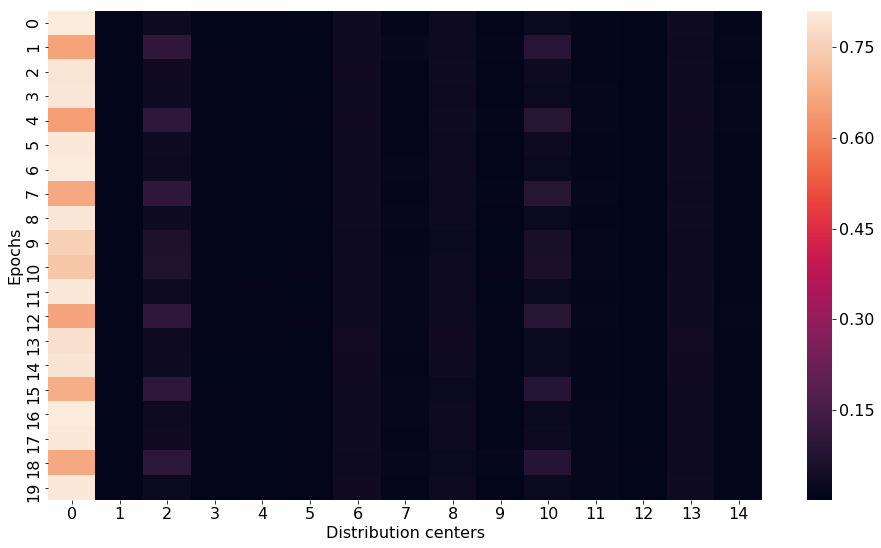

In [20]:
heatmap_epochs = np.zeros(shape=(total_epochs, onlineEM.m))

for i in range(total_epochs):
    df = df_all[(df_all.index > i * time_epoch) & (df_all.index <= (i + 1) * time_epoch)]
    groupped_data_epoch, _ = group_scale_data_batch(df, parameters)
    data = groupped_data_epoch.values[:,[0,1,3]]
    
    f = onlineEM.calculate_participation(data)

    temp_sum = f.sum(axis=0)
    
    heatmap_epochs[i] = temp_sum / sum(temp_sum)
    
    
ax = sns.heatmap(heatmap_epochs)
plt.ylabel('Εpochs')
plt.xlabel('Distribution centers')
plt.show()

In [21]:
onlineEM.gammas

array([ 0.7609081 ,  0.00108259,  0.05256596,  0.00400275,  0.00295882,
        0.00415552,  0.03284515,  0.00996914,  0.02852881,  0.00566783,
        0.04427433,  0.00958645,  0.00307774,  0.03113183,  0.009245  ])

In [22]:
onlineEM.lambdas

array([[1.0, 1.0],
       [60.51857702902319, 65.96037054238235],
       [13.25934877016046, 25.24159096973289],
       [16.829478586653302, 70.57445019233911],
       [40.611209035708555, 35.05434300941856],
       [32.08795446406958, 44.148625685947714],
       [13.933172644810202, 43.484688158119255],
       [52.340514272344045, 45.86606390676079],
       [13.891504868814396, 43.63039441857305],
       [21.211192292275236, 27.56859808464588],
       [13.260453167398891, 25.24659728811838],
       [32.57373715699095, 41.21688476239662],
       [32.3589693172082, 39.06110208557304],
       [13.900287458898118, 43.598780730573104],
       [23.063225412760172, 41.188393126380774]], dtype=object)